In [6]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats
import utils.plot
import models.train_metaClf

from matplotlib.colors import LinearSegmentedColormap
import squidpy as sq
import anndata as ad

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

resolution='5'
savedir_baseline='/data/xzhang/neuro/results/jointClustering/baseline/res'+resolution
with open(os.path.join(savedir_baseline,'pca_dapi_600'), 'rb') as output:
    pca_dapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_gfap_600'), 'rb') as output:
    pca_gfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_map2_600'), 'rb') as output:
    pca_map2=pickle.load(output)
with open(os.path.join(savedir_baseline,'pca_lmnb_600'), 'rb') as output:
    pca_lmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'modAll'), 'rb') as output:
    modAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'silAll'), 'rb') as output:
    silAll=pickle.load(output)
with open(os.path.join(savedir_baseline,'moddapi'), 'rb') as output:
    moddapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'sildapi'), 'rb') as output:
    sildapi=pickle.load(output)
with open(os.path.join(savedir_baseline,'modgfap'), 'rb') as output:
    modgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'silgfap'), 'rb') as output:
    silgfap=pickle.load(output)
with open(os.path.join(savedir_baseline,'modmap2'), 'rb') as output:
    modmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'silmap2'), 'rb') as output:
    silmap2=pickle.load(output)
with open(os.path.join(savedir_baseline,'modlmnb'), 'rb') as output:
    modlmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'sillmnb'), 'rb') as output:
    sillmnb=pickle.load(output)
with open(os.path.join(savedir_baseline,'leidenRes3_10samples'), 'rb') as output:
    leidenResAll=pickle.load(output)
    
savedir_processed='/data/xzhang/neuro/processed'
resDir='/data/xzhang/neuro/results/plots/cnnvaeexp0_segNucall'
saveDir=os.path.join(savedir_baseline,'cnnvaeexp0_segNucall')
if not os.path.exists(saveDir):
    os.mkdir(saveDir)


with open(os.path.join(resDir,'leiden_res'+resolution), 'rb') as output:
    finalPartition=pickle.load(output)
    
jointPartition=np.copy(finalPartition)
modFrac=0.3
modFrac_dapi=(moddapi/modAll>modFrac).astype(int)
modFrac_map2=(modmap2/modAll>modFrac).astype(int)
modFrac_gfap=(modgfap/modAll>modFrac).astype(int)
modFrac_lmnb=(modlmnb/modAll>modFrac).astype(int)
modFrac_sum=modFrac_dapi+modFrac_gfap+modFrac_lmnb+modFrac_map2

silAll_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_mean[c]=np.mean(silAll[jointPartition==c])
    
sildapi_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_mean[c]=np.mean(sildapi[jointPartition==c])
    
silgfap_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_mean[c]=np.mean(silgfap[jointPartition==c])

silmap2_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_mean[c]=np.mean(silmap2[jointPartition==c])
sillmnb_mean=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_mean[c]=np.mean(sillmnb[jointPartition==c])
silAll_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silAll_pos[c]=np.sum(silAll[jointPartition==c]>0)/np.sum(jointPartition==c)
sildapi_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sildapi_pos[c]=np.sum(sildapi[jointPartition==c]>0)/np.sum(jointPartition==c)
silmap2_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silmap2_pos[c]=np.sum(silmap2[jointPartition==c]>0)/np.sum(jointPartition==c)
silgfap_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    silgfap_pos[c]=np.sum(silgfap[jointPartition==c]>0)/np.sum(jointPartition==c)
sillmnb_pos=np.zeros(np.unique(jointPartition).size)
for c in np.unique(jointPartition):
    sillmnb_pos[c]=np.sum(sillmnb[jointPartition==c]>0)/np.sum(jointPartition==c)

silmean_frac=0.3
silmean_frac_neg=2
def comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg):
    silmean_frac_dapi=np.zeros(silAll_mean.size)
    sildapi_mean_posIdx=np.arange(silAll_mean.size)[sildapi_mean>0]
    sildapi_mean_negIdx=np.arange(silAll_mean.size)[sildapi_mean<0]
#     print(sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)])
    silmean_frac_dapi[sildapi_mean_posIdx[sildapi_mean[sildapi_mean>0]>(silAll_mean[sildapi_mean>0]*silmean_frac)]]=1
    silmean_frac_dapi[sildapi_mean_negIdx[sildapi_mean[sildapi_mean<0]>(silAll_mean[sildapi_mean<0]*silmean_frac_neg)]]=1

    return silmean_frac_dapi

silmean_frac_dapi=comparesilmean(sildapi_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_gfap=comparesilmean(silgfap_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_map2=comparesilmean(silmap2_mean,silAll_mean,silmean_frac,silmean_frac_neg)
silmean_frac_lmnb=comparesilmean(sillmnb_mean,silAll_mean,silmean_frac,silmean_frac_neg)

silmean_frac_sum=silmean_frac_dapi+silmean_frac_gfap+silmean_frac_map2+silmean_frac_lmnb

silpos_frac=0.3
silpos_dapi=(sildapi_pos/silAll_pos>silpos_frac).astype(int)
silpos_gfap=(silgfap_pos/silAll_pos>silpos_frac).astype(int)
silpos_map2=(silmap2_pos/silAll_pos>silpos_frac).astype(int)
silpos_lmnb=(sillmnb_pos/silAll_pos>silpos_frac).astype(int)

silPos_sum=silpos_dapi+silpos_gfap+silpos_map2+silpos_lmnb


clusterIdx_pass=np.arange(np.unique(finalPartition).size)[(modFrac_sum>1)+(silmean_frac_sum>1)+(silPos_sum>1)]

nsamples=10
leidenJoint_overlap=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(leidenResAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

overlap_mean=np.mean(leidenJoint_overlap,axis=1)
overlap_std=np.std(leidenJoint_overlap,axis=1)

randomAll=np.zeros((leidenResAll.shape[0],nsamples)).astype(int)

for s in range(nsamples):
    randomS=np.copy(jointPartition)
    np.random.seed(s)
    np.random.shuffle(randomS)

    randomAll[:,s]=randomS
leidenJoint_overlap_random=np.zeros((np.unique(jointPartition).size,nsamples))
for cj in np.unique(jointPartition):
    for s in range(nsamples):
        _,counts=np.unique(randomAll[jointPartition==cj,s],return_counts=True)
        leidenJoint_overlap_random[cj,s]=np.max(counts)/np.sum(jointPartition==cj)

overlap_mean_random=np.mean(leidenJoint_overlap_random,axis=1)
overlap_std_random=np.std(leidenJoint_overlap_random,axis=1)

clusterIdx_robust=np.arange(np.unique(finalPartition).size)[(overlap_mean-overlap_std)>(overlap_mean_random+overlap_std_random)]
finalPartition_keep=np.intersect1d(clusterIdx_robust,clusterIdx_pass)


    
with open(os.path.join(savedir_processed,'meta_processed'), 'rb') as output:
    meta=pickle.load(output)

# annoUsed=np.array(['AAO', 'AAD', 'Duration', 'Gender','Clinical Diag','Brain Weight', 'Mutations',
#                    'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43'])
annoUsed=np.array(['Path Diag','Clinical Diag','Brain Weight', 'Mutations',
                   'APOE', 'Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD','alpha-syn', 'TDP43',
                   'AAO', 'AAD', 'Duration', 'Gender'])
annoUsed_numeric=np.array(['AAO', 'AAD', 'Duration','Brain Weight','Braak Tau', 'Thal Phase', 'CERAD', 'CAA', 'SVD'])

meta=meta[annoUsed]
stains=np.array(['DAPI','GFAP','MAP2','LMNB'])

    
finalPartition_keepIdx=np.repeat(False, finalPartition.size)
for c in finalPartition_keep:
    finalPartition_keepIdx[finalPartition==c]=True
finalPartition_keep_input=np.copy(finalPartition)
finalPartition_keep_input[np.logical_not(finalPartition_keepIdx)]=-1



In [25]:
with open(os.path.join(savedir_processed,'allPatientID'), 'rb') as output:
    allPatientIDs=pickle.load(output)
meta=meta.loc[np.unique(allPatientIDs)]

with open(os.path.join(savedir_processed,'allImgNames'), 'rb') as output:
    allImgNames=pickle.load(output)
print(np.unique(allImgNames).size)
print(np.unique(allPatientIDs).size)

with open(os.path.join(savedir_processed,'allCoord'), 'rb') as output:
    allCoord=pickle.load(output)

64
50


In [4]:
allCoord.shape

(97530, 2)

In [5]:
#two main neighborhood patterns
neigh1_cluster=np.array([ 0.,  3., 13., 14., 18., 36., 39., 62., 66., 74., 82., 94.])
neigh2_cluster=np.array([ 1.,  4., 11., 17., 21., 28., 32., 53., 97., 99.])

In [9]:
cluster2plot=[neigh1_cluster,neigh2_cluster]
spcluster=np.zeros((finalPartition_keep_input.size,len(cluster2plot)))
for clusterIdx in range(len(cluster2plot)):
    c=cluster2plot[clusterIdx]

    for ci in c:
        spcluster[finalPartition_keep_input==ci,clusterIdx]=1
        
adata = ad.AnnData(X=spcluster)
adata.var_names = ["cluster_0", "cluster_1"]
adata.obsm["spatial"] = allCoord
adata

AnnData object with n_obs × n_vars = 97530 × 2
    obsm: 'spatial'

In [ ]:
#moran's I
dataDir='/data/xzhang/neuro'
proj2dpath='TIFS/2DMaxProj/2DMaxProj'
phenoLabels=['Control','AD','IPD','FTLD-TDPC','PSP']
plotMeta=['Path Diag','APOE','TDP43','alpha-syn']
# colors = ['blue', 'gold', 'chocolate']


imgSize=128
radius=int(imgSize/2)


moranI_neighRes={}
for i in range(len(cluster2plot)):
    moranI_neighRes[i]={}
    
for p in phenoLabels:
    print(p)
    
    for s in os.listdir(os.path.join(dataDir,p,proj2dpath,'DAPI')):
        print(s)
        
        sname=s.split('.')[0]
        
#         currImgName=np.repeat(sname,imgCount)
        currPatientID=sname.split('-')[0]+'-'+sname.split('-')[1]
        
        imgIdx=allImgNames==sname

        curr_adata=adata[imgIdx]
        sq.gr.spatial_neighbors(curr_adata, coord_type="generic")
        sq.gr.spatial_autocorr(curr_adata, mode="moran", genes=["cluster_0", "cluster_1"])
        curr_adata.uns["moranI"]
        
        for anno in plotMeta:
            anno_curr=meta.loc[currPatientID][anno]
            if anno!='Path Diag':
                if np.isfinite(float(anno_curr)):
                    anno_curr=str(int(anno_curr))
                else:
                    continue
            if anno+'_'+anno_curr=='APOE_24':
                continue
                
            for i in range(len(cluster2plot)):
                
                if anno+'_'+anno_curr not in moranI_neighRes[i].keys():
                    moranI_neighRes[i][anno+'_'+anno_curr]=[]

                if curr_adata.uns["moranI"].loc['cluster_'+str(i),'pval_norm']>=0.05:
                    moranI_neighRes[i][anno+'_'+anno_curr].append(0)
                else:
                    moranI_neighRes[i][anno+'_'+anno_curr].append(curr_adata.uns["moranI"].loc['cluster_'+str(i),'I'])
                
                if anno=='Path Diag':
                    print('\t cluster',i)
                    print('\t moranI',moranI_neighRes[i][anno+'_'+anno_curr][-1])


In [55]:
from scipy.stats import mannwhitneyu

('Path Diag_Control', 'Path Diag_AD') 0.04361122058106604
('Path Diag_Control', 'Path Diag_FTLD-TDPC') 0.00212874619946242
('Path Diag_Control', 'Path Diag_PSP') 0.10997114562625915
('Path Diag_Control', 'Path Diag_IPD') 0.05067118903663146
('APOE_33', 'APOE_34') 0.008161645310194435
('TDP43_0', 'TDP43_1') 0.4189540738413149
('alpha-syn_0', 'alpha-syn_1') 0.3923489894312464


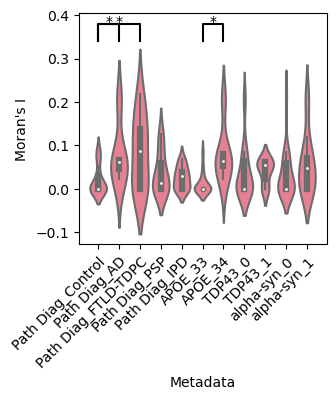

('Path Diag_Control', 'Path Diag_AD') 0.04361122058106604
('Path Diag_Control', 'Path Diag_FTLD-TDPC') 0.00212874619946242
('Path Diag_Control', 'Path Diag_PSP') 0.10997114562625915
('Path Diag_Control', 'Path Diag_IPD') 0.05067118903663146
('APOE_33', 'APOE_34') 0.008161645310194435
('TDP43_0', 'TDP43_1') 0.4189540738413149
('alpha-syn_0', 'alpha-syn_1') 0.3923489894312464


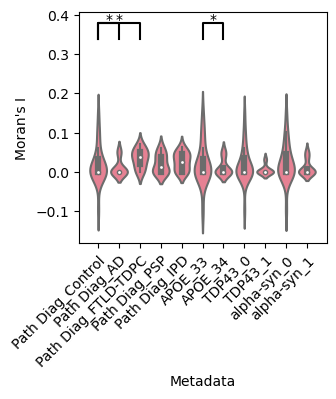

In [126]:

# Prepare data for plotting
data_list = []
plotorder = ['Path Diag_Control','Path Diag_AD', 'Path Diag_FTLD-TDPC', 'Path Diag_PSP','Path Diag_IPD', 'APOE_33','APOE_34', 'TDP43_0','TDP43_1','alpha-syn_0','alpha-syn_1']

for split, categories in moranI_neighRes.items():
    for category, values in categories.items():
        for value in values:
            data_list.append({"Metadata": category, "Moran's I": value, "Spatial cluster": split})

# Convert to DataFrame
df = pd.DataFrame(data_list)

# Compute p-values for comparisons
def compute_p_value(group1, group2, metadata_column, value_column):
    group1_values = df[df[metadata_column] == group1][value_column]
    group2_values = df[df[metadata_column] == group2][value_column]
    stat, p_value = mannwhitneyu(group1_values, group2_values, alternative='less')
    return p_value

# List of comparisons (only comparing relevant categories)
comparisons = [
    ('Path Diag_Control', 'Path Diag_AD'),
    ('Path Diag_Control', 'Path Diag_FTLD-TDPC'),
    ('Path Diag_Control', 'Path Diag_PSP'),
    ('Path Diag_Control', 'Path Diag_IPD'),
    ('APOE_33', 'APOE_34'),
    ('TDP43_0', 'TDP43_1'),
    ('alpha-syn_0', 'alpha-syn_1')
]

# Store p-values for significance markers
for i in range(2):
    p_values = {}
    for comparison in comparisons:
        group1, group2 = comparison
        p_values[comparison] = compute_p_value(group1, group2, 'Metadata', "Moran's I")

    # Plot violin plot with significance markers
    plt.figure(figsize=(3.2, 3))
    sns.violinplot(data=df[df['Spatial cluster'] == i], x="Metadata", y="Moran's I", hue="Spatial cluster", split=False, palette="husl", order=plotorder)

    plt.legend([],[], frameon=False)
    # Annotate significant p-values with asterisks
    for comparison, p_value in p_values.items():
        group1, group2 = comparison
        print(comparison,p_value)
        if p_value < 0.05:
            x1 = plotorder.index(group1)
            x2 = plotorder.index(group2)
            plt.plot([x1, x1, x2, x2], [1.04-0.7, 1.08-0.7, 1.08-0.7, 1.04-0.7], color='black')
            plt.text((x1 + x2) / 2, 1.07-0.7, f"*", ha='center', va='bottom', color='black')

    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for readability
    plt.show()
